# Classifiez automatiquement des biens de consommation

Vous êtes Data Scientist au sein de l’entreprise "**Place de marché**”, qui souhaite lancer une marketplace e-commerce.


Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible et dans l'optique d'un passage à l'échelle, **il devient nécessaire d'automatiser cette tâche**.

**Linda**, lead data scientist, vous demande donc d'étudier la faisabilité d'un **moteur de classification** des articles en différentes catégories, avec un niveau de précision suffisant.

## Les données
Linda vous a fourni un premier jeu de données d’articles avec le lien pour télécharger la photo et une description associée.

## Votre mission
Votre mission est de **réaliser une première étude de faisabilité d'un moteur de classification** d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

Vous **analyserez le jeu de données** en **réalisant un prétraitement** des images et des descriptions des produits, une **réduction de dimension**, puis un **clustering**. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

La représentation graphique vous aidera à convaincre Linda que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

Attention, Linda n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité !

__Contraintes__
Linda vous a communiqué la contrainte suivante : afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF.

Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration.

## Livrables attendus
Un **notebook** (ou des fichiers .py) contenant les fonctions permettant le prétraitement des données textes et images ainsi que les résultats du clustering (en y incluant des représentations graphiques au besoin).
Un support de **présentation** qui présente la démarche et les résultats du clustering.

# Analyse exploratoire des données textuelles

**[I Préparation du jeu de données](#I-Préparation-du-jeu-de-données)**
* [I.1 Chargement du jeu de données](#I.1-Chargement-du-jeu-de-données)
* [I.2 Création des catégories](#I.2-Création-des-catégories)

**[II Création du corpus](#II-Création-du-corpus)**

**[III Nettoyage et normalisation du corpus](#III-Nettoyage-et-normalisation-du-corpus)**
* [III.1 Tokenization](#III.1-Tokenization)
* [III.2 Stopwords](#III.2-Stopwords)
* [III.3 Lemmatization](#III.3-Lemmatization)
* [III.4 Résumé - fonctions de prétraitement](#III.4-Résumé---fonctions-de-prétraitement)

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import itertools
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np 
from numpy.random import default_rng
import re
import p6

from langdetect import DetectorFactory
DetectorFactory.seed = 0
from langdetect import detect
from langdetect import detect_langs

from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

import sys

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from sklearn import manifold
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import cluster

import hdbscan

/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

# I Préparation du jeu de données

## I.1 Chargement du jeu de données

Commençons par charger le jeu de données

In [2]:
try:
    data = p6.load_data()
except:
    rootpath = "./data/Flipkart/"
    data = pd.read_csv(rootpath+"flipkart_com-ecommerce_sample_1050.csv")
    data.head()

Les données qui vont nous intéresser ici appartiennent sont:
- les descriptions des produits
- les noms des produits

## I.2 Création des catégories

In [3]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


Nombre de catégories différentes par niveau:
--------------------------------------------------
0      7
1     62
2    241
3    349
4    297
5    117
6     57
dtype: int64


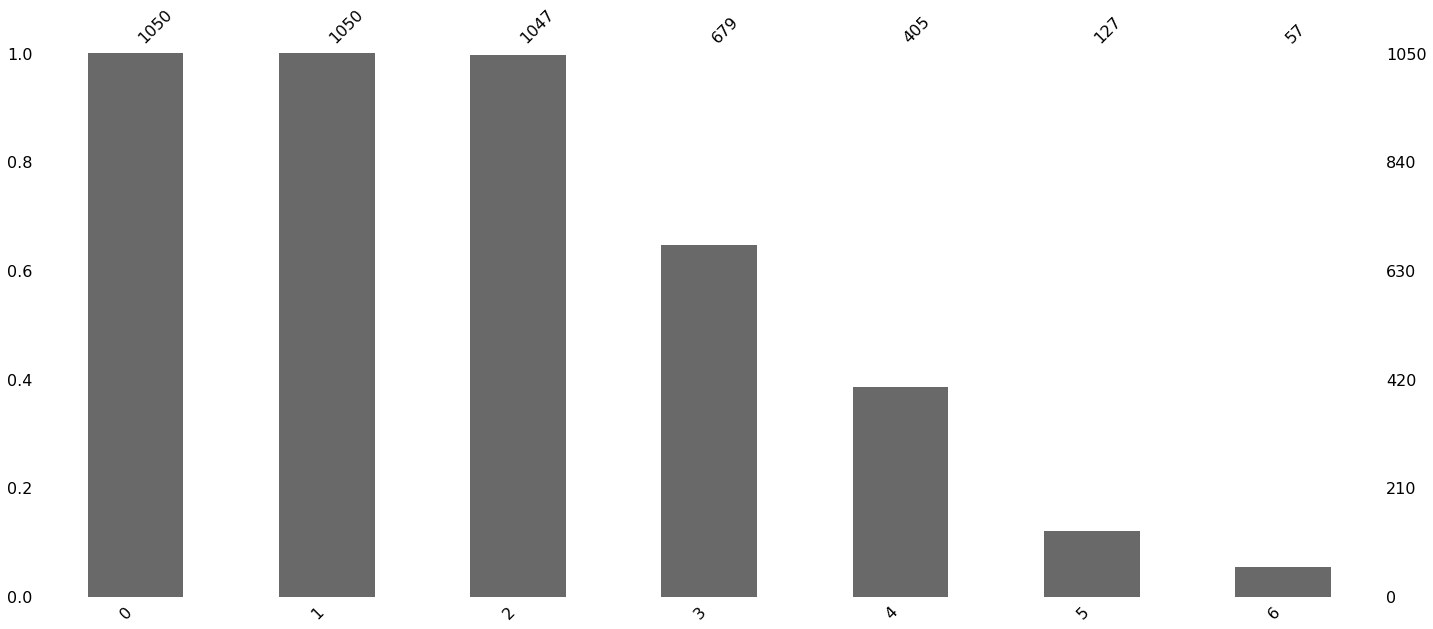

In [4]:
categories = p6.category_trees(data)
msno.bar(categories)
print("Nombre de catégories différentes par niveau:")
print("-"*50)
print(categories.nunique())

In [7]:
data["product_category_0"] = p6.extract_categories_from_tree(data)
data["product_category_1"] = p6.extract_categories_from_tree(data, level=1)
data = data[["product_name", "description", "product_category_0", "product_category_1"]]
data.head()

,product_name,description,product_category_0,product_category_1
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen


**Combien de produits par catégorie? Les catégories sont-elles équilibrées?**

In [122]:
data.groupby('product_category_0').size()

product_category_0
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
dtype: int64

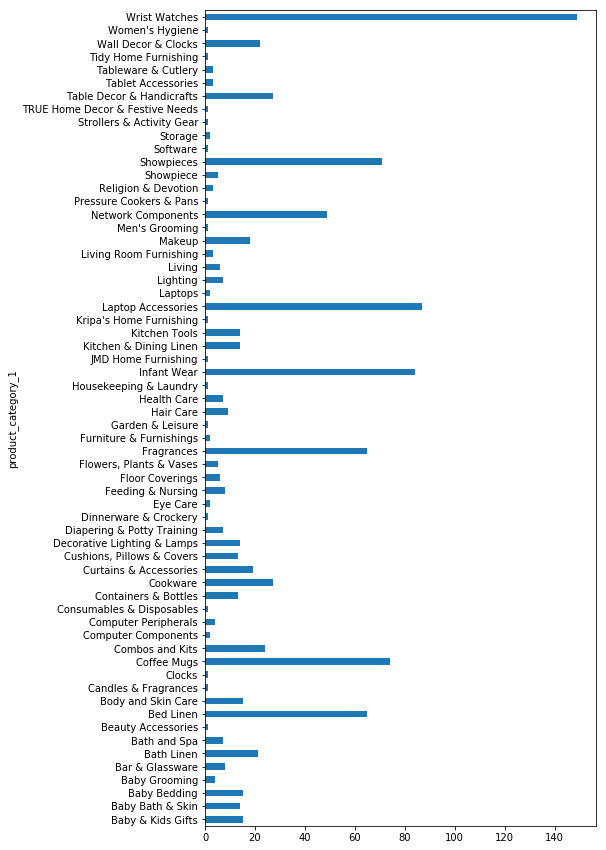

In [129]:
plt.figure(figsize=(7, 15))
data.groupby('product_category_1').size().plot(kind='barh')

Au deuxième niveau de catégorisation, les catégories ne sont plus du tout équilibrées. Ceci suggère que les produits ont été choisis (aléatoirement?) de manière à ce que chaque catégorie de niveau 0 soit représentée également.

# II Création du corpus

## II.1 Affichage d'exemples choisis aléatoirement

On commence par écrire une petite routine qui va nous permettre d'afficher une description de produit choisie au hasard dans la liste des descriptions (data["description"])

In [10]:
def get_sample(n=1):
    """Returns a raw sample form the corpus"""
    sample = data["description"].sample(n).values
    return sample

Affichons 10 exemples tirés au hasard:

In [12]:
print(get_sample(10))

["Rega IT Hp Pavilion DV2535TX DV2536TX 12 Cell 12 Cell Laptop Battery\r\n                         Price: Rs. 2,499\r\n\t\t\t\t\r\n\t\t\tRega IT Replacement 12 Cell (Extended) Laptop Battery for Hp Pavilion DV2535TX DV2536TX Laptop Made from highest quality parts each Rega IT replacement Battery confirms to specifications similar and guaranteed to meet or exceed your laptop's minimum requirements. Each Battery also passes necessary authentication certifications like CE, ROHS etc. Before leaving the factory, so you can be rest assured for its quality, durability and performance. Please make sure that you are selecting the correct Battery as per you old Battery specification. Please compare your old Battery Power Rating i.e. Volts (V), Capacity (mAh) & Cells.\r\nRega IT Replacement 12 Cell (Extended) Laptop Battery for Hp Pavilion DV2535TX DV2536TX Laptop Made from highest quality parts each Rega IT replacement Battery confirms to specifications similar and guaranteed to meet or exceed y

On remarque que le texte est en anglais sur ces exemples, qu'il y a du texte ainsi que des nombres et ce qui semble être des numéros de séries ainsi que des abréviations. Il y a également des url ainsi que des caractères spéciaux. On remarque également d'ors-et-déjà la présence de phrases telles que "cash on delivery", "free shipping" etc. qui semblent revenir souvent mais ne présentent aucun intérêt du point de vue de la catégorisation des produits. On pourra songer à les éliminer du dataset dès le prétraitement, même si elles seront sans doute filtrées lors du calcul de la matrice tf-idf. Quoi qu'il en soit il faudra tenir compte de tout ces éléments pour réaliser une tokenization efficace du corpus.

# III Nettoyage et normalisation du corpus
## III.0 Vérification du langage utilisé

On commence par nettoyer le corpus: on retire les caractères spéciaux

In [13]:
def clean_sample(sample):
    
    cleaned_sample = re.sub('\n|\r|\t', ' ', sample)
    cleaned_sample = re.sub('\s{2,}', ' ', cleaned_sample)
    
    return cleaned_sample

In [14]:
detected = list()
for sample in tqdm(data.description):
    cleaned_sample = clean_sample(sample)
    detected.append([(dl.lang, dl.prob) for dl in detect_langs(cleaned_sample)])

100%|██████████| 1050/1050 [00:14<00:00, 70.85it/s]


In [39]:
raw_detected = pd.DataFrame(detected)
first_lang = pd.DataFrame.from_records(raw_detected[0].tolist(), columns=["first_lang", "first_prob"])
d = pd.concat([first_lang, raw_detected[1]], axis=1)
d[1] = d[1].apply(lambda x: (x, x) if x is None else x)

second_lang = pd.DataFrame.from_records(d[1].tolist(), columns=["second_lang", "second_prob"])
detected_languages = pd.concat([d.drop(columns=1), second_lang], axis=1)
detected_languages.head()

,first_lang,first_prob,second_lang,second_prob
0,en,0.999996,None,NaN
1,en,0.999996,None,NaN
2,en,0.999999,None,NaN
3,en,0.999995,None,NaN
4,en,0.999996,None,NaN


In [40]:
# ISO-codes for languages
wiki_page = pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes')
iso_codes = wiki_page[1][["ISO language name", "639-1"]]
iso_codes.head()

,ISO language name,639-1
0,Abkhazian,ab
1,Afar,aa
2,Afrikaans,af
3,Akan,ak
4,Albanian,sq


In [41]:
# Langages utilisés dans le dataset:
detected_languages["first_lang"] = (detected_languages.first_lang
 .apply(lambda x: iso_codes.loc[iso_codes["639-1"]==x, "ISO language name"].values[0])
)

detected_languages["second_lang"] = (detected_languages["second_lang"]
                                    .apply(lambda x: iso_codes.loc[iso_codes["639-1"]==x, "ISO language name"]
                                           .values[0] 
                                           if x else x)
                                    )

In [55]:
print("Langue(s) principale(s) détectée(s): " + ", ".join([fl for fl in detected_languages.first_lang.unique()]))
print("Langue(s) secondaire(s) détectée(s): " + ", ".join([fl for fl in detected_languages.second_lang.unique() if fl]))

Langue(s) principale(s) détectée(s): English
Langue(s) secondaire(s) détectée(s): Italian, Indonesian, German


In [56]:
detected_languages[detected_languages.second_lang.notna()]

,first_lang,first_prob,second_lang,second_prob
197,English,0.714283,Italian,0.285716
267,English,0.428573,Indonesian,0.285713
1013,English,0.857139,German,0.142858


In [57]:
sample = data.iloc[197]["description"]
sample

'Sam Rolling Pizza Cutter (Steel Pack of 1)\r\n                         Price: Rs. 45\r\n\t\t\t\t\r\n\t\t\tDurable Good Quality Pizza Cutter\r\nDurable Good Quality Pizza Cutter'

In [58]:
clean_sample(sample)

'Sam Rolling Pizza Cutter (Steel Pack of 1) Price: Rs. 45 Durable Good Quality Pizza Cutter Durable Good Quality Pizza Cutter'

In [18]:
sample = data.iloc[267]["description"]
sample

'Sahara Q Shop Kadhai 1.5 L (Stainless Steel)\r\n                         Price: Rs. 650\r\n\t\t\t\t\r\n\t\t\tPremium Non Stick Kadhai 1.5.Ltr\r\nPremium Non Stick Kadhai 1.5.Ltr'

In [19]:
clean_sample(sample)

'Sahara Q Shop Kadhai 1.5 L (Stainless Steel) Price: Rs. 650 Premium Non Stick Kadhai 1.5.Ltr Premium Non Stick Kadhai 1.5.Ltr'

In [20]:
sample = data.iloc[1013]["description"]
sample

'Key Features of LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray  -  For Men Fragrance Classification: Deodorant Spray,LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray  -  For Men (210 ml) Price: Rs. 447 Lawman Deodorant Combo For Men,Specifications of LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray  -  For Men (210 ml) Fragrance Traits Fragrance Classification Deodorant Spray Quantity 210 ml Ideal For Men In the Box 3 Deodorant'

In [21]:
clean_sample(sample)

'Key Features of LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray - For Men Fragrance Classification: Deodorant Spray,LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray - For Men (210 ml) Price: Rs. 447 Lawman Deodorant Combo For Men,Specifications of LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray - For Men (210 ml) Fragrance Traits Fragrance Classification Deodorant Spray Quantity 210 ml Ideal For Men In the Box 3 Deodorant'

Le détecteur de langue fonctionne bien la plupart du temps, c'est-à-dire qu'il reconnaît l'anglais comme la langue des descriptions. Dans quelques cas, le détecteur "croit" reconnaître d'autres langues, mais il s'agit manifestement de "faux" - d'ailleurs les probabilités associées sont plutôt basses comparé au 99%+ qu'on obtient généralement lorsqu'il n'y a pas d'ambiguité. L'ambiguité provient certainement de la présence de mots étrangers écrits avec l'alphabet latin (lorsque le détecteur s'attendrait à un autre alphabet, ou un autre langage utilisant l'alphabet latin), et peut-être de la présence de caractères spéciaux. Il faudrait en principe retirer ces caractères spéciaux avant de faire fonctionner le détecteur.
En conclusion: on va considérer qu'on n'a affaire qu'à de l'anglais dans ce dataset.

## III.1 Fonctions de prétraitement

In [8]:
# création du set de stopwords
SW = set()
SW.update(nltk.corpus.stopwords.words('english'))
SW.update(STOP_WORDS)

# fonctions de lemmatization et tokenization
lemmatizer = WordNetLemmatizer()

# motif regex pour la tokenization. Ce motif filtre directement les caractères spéciaux comme 
# \n, \t \r etc., ainsi que les chiffres.
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')
    
def prepare_text(sample, **kwargs):
    # création d'un motif regex à partir de quelques phrases récurrentes et non-informatives. 
    sentences_to_remove = ['rs.', 
                           'flipkart.com',
                           'free shipping',
                           'cash on delivery', 
                           'only genuine products', 
                           '30 day replacement guarantee',
                           '\n',
                           '\r',
                           '\t',
                           r'\bcm\b',
                           r'\bbuy\b',
                           r'\bl\b'
                          ]

    sent_rm = kwargs.pop('sentences_to_remove', sentences_to_remove)
    pattern = "|".join(sentences_to_remove)
    cleaned_text = re.sub(pattern, ' ', sample)
    pattern_2 = re.compile(r"\s{2,}")
    cleaned_text = re.sub(pattern_2, ' ', cleaned_text)
    return cleaned_text

def get_lemma(tokens, lemmatizer, stop_words):
    lemmatized = []
    for item in tokens:
        if item not in stop_words:
            lemmatized.append(lemmatizer.lemmatize(item))
    return lemmatized


def tokenize(sample, **kwargs):
    tokenizer = kwargs.pop('tokenizer', None)
    if tokenizer:
        tokens = tokenizer.tokenize(sample)
        lemma = kwargs.pop('lemmatizer', None)
        stop_w = kwargs.pop('stop_words', None)
        if lemma:
            if stop_w:
                lemmas = get_lemma(tokens, lemmatizer, stop_w)
            else:
                lemmas = get_lemma(tokens, lemmatizer)
        else:
            lemmas = tokens
        
        return lemmas
    else:
        print("Missing tokenizer") 
        
    


def process_text(sample):
    # motif regex pour la tokenization. Ce motif filtre directement les caractères spéciaux 
    # comme \n, \t \r etc., ainsi que les chiffres.
    pattern = re.compile(r'[a-zA-Z]+')
    cleaned = prepare_text(sample)
    tokens = tokenize(cleaned, tokenizer=tokenizer,lemmatizer=lemmatizer,stop_words=SW)

    return ' '.join(tokens)

**Démonstration de la tokenization sur un exemple**

In [9]:
s = data.description.sample(1).to_numpy()[0].lower()
print("Texte original")
print("-"*14)
s

Texte original
--------------


'buy prithish gemini black ceramic mug for rs.275 online. prithish gemini black ceramic mug at best prices with free shipping & cash on delivery. only genuine products. 30 day replacement guarantee.'

In [10]:
print("Après tokenization")
print("-"*18)
print(process_text(s))

Après tokenization
------------------
prithish gemini black ceramic mug online prithish gemini black ceramic mug best price


# IV Création des bag-of-words

## IV.1 Préparation du corpus (preprocessing)

### IV.1.1 tokenization, lemmatization

In [11]:
tokenized_corpus = [process_text(desc.lower()) for desc in data.description]
tokenized_corpus = np.asarray(tokenized_corpus, dtype='object')

In [258]:
tokenized_corpus[0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price curtain enhances look interio curtain high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart fi thing morning welcome bright sun ray want wish good morning world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filte light room right sunlight specification elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model abstract polyester door curtain set model id duster color multicolor dimension length box number content sale package pack sale package curtain body des

### IV.1.2 Analyse exploratoire: mots les plus fréquents par catégorie de produits

In [12]:
most_frequent = dict()
for cat in data.product_category_0:
    cat_indices = data[data.product_category_0==cat].index.tolist()
    word_count = Counter()
    for text in tokenized_corpus[cat_indices]:
        for token in text.split(' '):
            word_count[token] += 1
    most_frequent[cat] = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

In [13]:
print("mots les plus fréquents par catégorie de produit")
print("-"*50)
print()
for cat in data.product_category_0.unique():
    print(cat)
    print('-'*15)
    print(', '.join([m for m in list(zip(*most_frequent[cat]))[0][:20]]))
    print()

mots les plus fréquents par catégorie de produit
--------------------------------------------------

Home Furnishing
---------------
cotton, pack, cover, design, towel, cushion, inch, package, sale, polyester, color, material, single, price, feature, multicolor, curtain, width, blanket, floral

Baby Care
---------------
baby, girl, cotton, detail, fabric, boy, dress, specification, ideal, general, package, feature, sleeve, type, sale, neck, wash, number, pattern, content

Watches
---------------
watch, analog, men, online, india, great, discount, woman, dial, strap, boy, resistant, water, round, sonata, maximum, digital, girl, case, black

Home Decor & Festive Needs
---------------
showpiece, price, best, inch, wall, online, home, color, feature, brass, number, product, gift, art, material, box, dimension, beautiful, package, x

Kitchen & Dining
---------------
mug, ceramic, coffee, perfect, price, material, design, gift, ml, feature, specification, safe, product, pack, quality, loved,

Certains mots apparaissent dans plusieurs catégories de produit. Cela peut potentiellement nuire à la segmentation, il faudra voir comment les filtrer (ou les utiliser).\
On peut regarder quels sont les mots parmi les 10 mots les plus utilisés qui reviennent dans plusieurs catégories

In [10]:
setlist = [set(list(zip(*most_frequent[cat]))[0][:10]) for cat in data.product_category_0]
set.intersection(*setlist)

set()

Aucun mot parmi les 10 plus fréquents de chaque catégorie n'apparaît dans toutes les catégories. A l'inverse, on peut regarder quels sont les mots qui reviennent dans chaque paire de catégorie.

In [14]:
intersect = []
for comb_cat in itertools.combinations(data.product_category_0.unique(), 2):
    setlist = [set(list(zip(*most_frequent[cat]))[0][:20]) for cat in comb_cat]
    intersect.append(set.intersection(*setlist))
multi_category_words = set(itertools.chain.from_iterable(intersect))
multi_category_words

{'best',
 'box',
 'boy',
 'color',
 'cotton',
 'design',
 'feature',
 'gift',
 'girl',
 'ideal',
 'inch',
 'material',
 'ml',
 'number',
 'online',
 'pack',
 'package',
 'price',
 'product',
 'quality',
 'sale',
 'skin',
 'specification',
 'type'}

Ces mots sont donc des mots qui sont fréquemment utilisés dans au moins deux catégories. On peut essayer de les supprimer, car ils contribuent à rendre les distinctions entre catégories moins nettes.

## IV.2 Processing pipeline
### IV.2.1 Représentation "bag-of-words" - _Document-term matrix_

In [19]:
def make_docterm_matrix(corpus, idf_transform=True, **kwargs):
    
    max_df = kwargs.pop('max_df', 1.0)
    min_df = kwargs.pop('min_df', 1)
    cvargs = {'max_df':max_df, 'min_df':min_df}
    
    cv = CountVectorizer(**cvargs)
    values = cv.fit_transform(corpus)
    docterm = pd.DataFrame(values.todense(), columns=cv.get_feature_names())
    
    max_tf = kwargs.pop('max_tf', docterm.sum(axis=0).max())
    min_tf = kwargs.pop('min_tf', 1)
    multi_cat_words = kwargs.pop('multi_cat', None)
    words_to_drop = set()
    words_to_drop.update([c for c in docterm.columns if (docterm[c].sum()<min_tf)])
    words_to_drop.update([c for c in docterm.columns if (docterm[c].sum()>max_tf)])
    
    if multi_cat_words:
        words_to_drop.update(multi_cat_words)
        
    df = docterm.drop(columns=words_to_drop, errors='ignore')
    
    if idf_transform:
        tfidf = TfidfTransformer()
        values = tfidf.fit_transform(df)
        df = pd.DataFrame(values.todense(), columns=df.columns)
    
    return df

docterm = make_docterm_matrix(tokenized_corpus,
                              idf_transform=True,
                              min_tf=10,
                              max_tf=400,
                              min_df=2,
                              max_df=0.5
                              #multi_cat=multi_category_words  
                              )
docterm.head()

,absorbent,abstract,ac,accessory,actual,adapte,adapter,add,addition,additional,...,wooden,work,world,wow,wrap,yea,year,yellow,yes,ym
0,0.0,0.192247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.063366,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.196594,0.077037,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.052665,0.0,0.000000,0.000000,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.045189,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.036370,0.0


## IV.5 Apprentissage non-supervisé de catégories de produits par LDA

### IV.5.1 Topics

In [20]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 7

# Créer le modèle LDA
lda = LatentDirichletAllocation(
    n_components=n_topics, 
    max_iter=10, 
    learning_method='batch')

# Fitter sur les données - on utilise la matrice "bag-of-words"
lda.fit(docterm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=7, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [21]:
# affichage des mots les plus représentatifs
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

no_top_words = 10
tf_feature_names = docterm.columns
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
ceramic mug prithish rockmantra pizza fresh ym design creation come

Topic 1:
kadhai lowest best warranty showpiece steel wall jewellery spf online

Topic 2:
towel cotton bath set product quality skin soft buddha high

Topic 3:
combo set online usb battery laptop cell hp light link

Topic 4:
showpiece abstract single double blanket cushion best cover multicolor quilt

Topic 5:
mug led coffee brass bulb light skin ml gift tea

Topic 6:
watch analog men india discount great woman boy online baby



### IV.5.2 Evaluation des catégories apprises par comparaison avec les vraies catégories

**Assignation des catégories à chaque produit**

In [22]:
# Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale
X_topics = lda.transform(docterm)
topics = np.argmax(X_topics, axis=1)
data["topics"] = topics

# Encodage numérique des vraies catégories
le = preprocessing.LabelEncoder()
labels = le.fit_transform(data.product_category_0)
label_classes = le.classes_
data['label'] = labels
data.head()

,product_name,description,product_category_0,product_category_1,topics,label
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories,6,4
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin,4,0
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin,2,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen,4,4
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen,4,4


**Evaluation grâce au adjusted rand index**

In [32]:
print("ARI : ", metrics.adjusted_rand_score(labels, topics))

ARI :  0.23978860008811098


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:124: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


**Inspection visuelle des catégories apprises via T-SNE**

In [41]:
import warnings
warnings.filterwarnings('ignore')

svd = decomposition.TruncatedSVD(n_components=100)
X = svd.fit_transform(docterm)

tsne = manifold.TSNE(perplexity=100, n_iter=2000)
clusters = tsne.fit_transform(X)

clust = pd.DataFrame(data=clusters, columns=["t-SNE 0", "t-SNE 1"])
df = pd.concat([clust, data.topics], axis=1)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue="topics", palette='tab10')

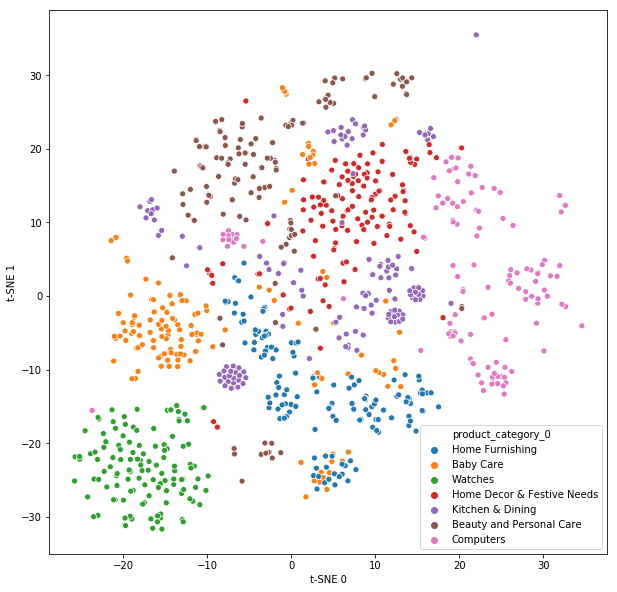

In [39]:
clust = pd.DataFrame(data=clusters, columns=["t-SNE 0", "t-SNE 1"])
df = pd.concat([clust, data.product_category_0], axis=1)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue="product_category_0", palette='tab10')

**Inspection de la matrice de confusion**

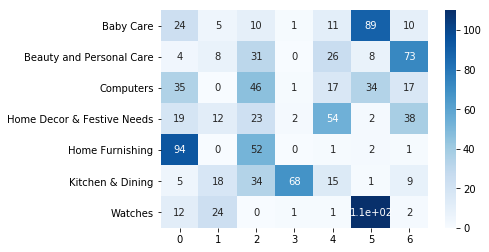

In [170]:
conf_mat = metrics.confusion_matrix(labels, topics)
df_cm = pd.DataFrame(conf_mat, index = [label for label in label_classes],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

Beaucoup de produits regroupés dans seulement 3 des 7 topics.

Latent semantic analysis? clustering with k-means? classification? use of word embeddings? maybe try a little more in-depth exploratory analysis of the "real" topics (i.e. the product catgories): what are the most frequent words in each topic? this could help to make the tokenization better.

## LDA Pipeline

In [616]:
def model_evaluation(corpus, idf_transform=False, **kwargs):
    
    # création de la matrice 'bag_of_words'
    docterm = make_docterm_matrix(corpus,
                                  idf_transform=idf_transform, 
                                  **kwargs
                                  )
    
    # Latent Dirichlet Allocation
    n_topics = 7
    lda = decomposition.LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='batch',
    
    )
    
    # Fit
    lda.fit(docterm)
    
    # Evaluation
    # Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale
    X_topics = lda.transform(docterm)
    topics = np.argmax(X_topics, axis=1)
    data["topics"] = topics
    
    # Encodage numérique des vraies catégories
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(data.product_category_0)
    label_classes = le.classes_
    data['label'] = labels
    data.head()
    
    # ARI
    
    return metrics.adjusted_rand_score(labels, topics)

In [414]:
min_tf = [1, 5, 10,15, 20, 30, 40, 50]
max_tf = [100,200, 400]
min_df = [1,2, 5, 10, 20, 50]
max_df = [0.5, 0.6, 0.7, 0.8, 0.95, 1.0]
mcw = [None,multi_category_words]
results = []

for mit in tqdm(min_tf):
    for mat in tqdm(max_tf):
        for mid in tqdm(min_df):
            for mad in tqdm(max_df):
                for mc in tqdm(mcw):
                    ari = model_evaluation(tokenized_corpus,
                                     min_df=mid,
                                     max_df=mad, 
                                     min_tf=mit,
                                     max_tf=mat,
                                     multi_cat=mc
                                    )
                    results.append([mit, mat, mid, mad, mc is not None, ari])

results = pd.DataFrame(data=results, columns=["min_tf", 
                                              "max_tf", 
                                              "min_df", 
                                              "max_df", 
                                              "multi_category_words",
                                              "adjusted Rand Index"
                                             ])

max_ari = results["adjusted Rand Index"].max()
index = results[results["adjusted Rand Index"]==max_ari].index[0]
best_params = results[results["adjusted Rand Index"]==max_ari].transpose().rename(columns={index:"Paramètres"})
print("Meilleur ARI: {:.3f}".format(max_ari))
print("Hyperparamètres utilisés pour obtenir le meilleur ARI: ")
print(best_params)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:07<00:07,  7.44s/it]



100%|██████████| 2/2 [00:14<00:00,  7.25s/it]



 17%|█▋        | 1/6 [00:14<01:12, 14.51s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:07<00:07,  7.21s/it]



100%|██████████| 2/2 [00:14<00:00,  7.16s/it]



 33%|███▎      | 2/6 [00:28<00:57, 14.44s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:07<00:07,  7.66s/it]



100%|██████████| 2/2 [00:14<00:00,  7.26s/it]



 50%|█████     | 3/6 [00:43<00:43, 14.51s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:07<00:07,  7.39s/it]



100%|██████████| 2/2 [00:14<00:00,  7.20s/it]



 67%|██████▋   | 4/6 [00:57<00:28, 14.49s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:08<00:08,  8.13s/it]



100%|██████████| 2/2 [00:15<00:00,  7.

100%|██████████| 2/2 [00:07<00:00,  3.55s/it]



 83%|████████▎ | 5/6 [00:35<00:07,  7.06s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.41s/it]



100%|██████████| 2/2 [00:06<00:00,  3.43s/it]



100%|██████████| 6/6 [00:42<00:00,  7.03s/it]


 83%|████████▎ | 5/6 [05:03<00:53, 53.19s/it]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:02<00:02,  2.69s/it]



100%|██████████| 2/2 [00:05<00:00,  2.68s/it]



 17%|█▋        | 1/6 [00:05<00:26,  5.38s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:02<00:02,  2.80s/it]



100%|██████████| 2/2 [00:05<00:00,  2.65s/it]



 33%|███▎      | 2/6 [00:10<00:21,  5.36s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:02<00:02,  2.61s/it]



100%|██████████| 2/2 [00:05<00:00,  2.52s/it]



 50%|█████     | 3/6 [00:15<00:15,  5.24s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 

100%|██████████| 2/2 [00:07<00:00,  3.55s/it]



 50%|█████     | 3/6 [00:20<00:21,  7.01s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.41s/it]



100%|██████████| 2/2 [00:06<00:00,  3.36s/it]



 67%|██████▋   | 4/6 [00:27<00:13,  6.90s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.54s/it]



100%|██████████| 2/2 [00:06<00:00,  3.46s/it]



 83%|████████▎ | 5/6 [00:34<00:06,  6.91s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.43s/it]



100%|██████████| 2/2 [00:06<00:00,  3.47s/it]



100%|██████████| 6/6 [00:41<00:00,  6.94s/it]


 67%|██████▋   | 4/6 [03:50<01:44, 52.48s/it]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:02<00:02,  2.78s/it]



100%|██████████| 2/2 [00:05<00:00,  2.77s/it]



 17%|█▋        | 1/6 [00:05<00:27,  5.55s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 

  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.80s/it]



100%|██████████| 2/2 [00:09<00:00,  4.67s/it]



 33%|███▎      | 2/6 [00:18<00:37,  9.34s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.87s/it]



100%|██████████| 2/2 [00:09<00:00,  4.79s/it]



 50%|█████     | 3/6 [00:28<00:28,  9.45s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:05<00:05,  5.88s/it]



100%|██████████| 2/2 [00:10<00:00,  5.18s/it]



 67%|██████▋   | 4/6 [00:38<00:19,  9.84s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:05<00:05,  5.07s/it]



100%|██████████| 2/2 [00:09<00:00,  4.85s/it]



 83%|████████▎ | 5/6 [00:48<00:09,  9.80s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:05<00:05,  5.04s/it]



100%|██████████| 2/2 [00:09<00:00,  4.85s/it]



100%|██████████| 6/6 [00:58<00:00,  9.69s/it]


 50%|█████     | 3/6 [03:36<03:26, 68.67s/it]


  0%|        

100%|██████████| 2/2 [00:13<00:00,  6.51s/it]



100%|██████████| 6/6 [01:19<00:00, 13.31s/it]


 17%|█▋        | 1/6 [01:19<06:39, 79.91s/it]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:05<00:05,  5.02s/it]



100%|██████████| 2/2 [00:10<00:00,  5.14s/it]



 17%|█▋        | 1/6 [00:10<00:51, 10.29s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.98s/it]



100%|██████████| 2/2 [00:10<00:00,  5.17s/it]



 33%|███▎      | 2/6 [00:20<00:41, 10.35s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:05<00:05,  5.10s/it]



100%|██████████| 2/2 [00:10<00:00,  5.04s/it]



 50%|█████     | 3/6 [00:30<00:30, 10.25s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:05<00:05,  5.10s/it]



100%|██████████| 2/2 [00:10<00:00,  5.08s/it]



 67%|██████▋   | 4/6 [00:41<00:20, 10.24s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 

 50%|█████     | 1/2 [00:03<00:03,  3.41s/it]



100%|██████████| 2/2 [00:06<00:00,  3.15s/it]



 83%|████████▎ | 5/6 [00:32<00:06,  6.44s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.62s/it]



100%|██████████| 2/2 [00:06<00:00,  3.27s/it]



100%|██████████| 6/6 [00:38<00:00,  6.49s/it]


100%|██████████| 6/6 [05:45<00:00, 57.52s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:06<00:06,  6.99s/it]



100%|██████████| 2/2 [00:12<00:00,  6.45s/it]



 17%|█▋        | 1/6 [00:12<01:04, 12.92s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:06<00:06,  6.04s/it]



100%|██████████| 2/2 [00:11<00:00,  5.98s/it]



 33%|███▎      | 2/6 [00:24<00:49, 12.37s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:06<00:06,  6.00s/it]



100%|██████████| 2/2 [00:11<00:00

 50%|█████     | 1/2 [00:03<00:03,  3.47s/it]



100%|██████████| 2/2 [00:06<00:00,  3.43s/it]



 50%|█████     | 3/6 [00:20<00:20,  6.85s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.21s/it]



100%|██████████| 2/2 [00:06<00:00,  3.25s/it]



 67%|██████▋   | 4/6 [00:27<00:13,  6.71s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.36s/it]



100%|██████████| 2/2 [00:06<00:00,  3.43s/it]



 83%|████████▎ | 5/6 [00:33<00:06,  6.77s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.39s/it]



100%|██████████| 2/2 [00:06<00:00,  3.40s/it]



100%|██████████| 6/6 [00:40<00:00,  6.80s/it]


 83%|████████▎ | 5/6 [04:37<00:49, 49.80s/it]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:02<00:02,  2.72s/it]



100%|██████████| 2/2 [00:05<00:00,  2.63s/it]



 17%|█▋        | 1/6 [00:05<00:26,  5.29s/it]



  0%|        

 50%|█████     | 1/2 [00:03<00:03,  3.15s/it]



100%|██████████| 2/2 [00:06<00:00,  3.24s/it]



 17%|█▋        | 1/6 [00:06<00:32,  6.50s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.18s/it]



100%|██████████| 2/2 [00:06<00:00,  3.24s/it]



 33%|███▎      | 2/6 [00:12<00:25,  6.50s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.27s/it]



100%|██████████| 2/2 [00:06<00:00,  3.24s/it]



 50%|█████     | 3/6 [00:19<00:19,  6.50s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.06s/it]



100%|██████████| 2/2 [00:06<00:00,  3.18s/it]



 67%|██████▋   | 4/6 [00:25<00:12,  6.45s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.16s/it]



100%|██████████| 2/2 [00:06<00:00,  3.24s/it]



 83%|████████▎ | 5/6 [00:32<00:06,  6.49s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.27s/it]



100%|██████

 50%|█████     | 1/2 [00:05<00:05,  5.55s/it]



100%|██████████| 2/2 [00:10<00:00,  5.22s/it]



100%|██████████| 6/6 [01:00<00:00, 10.11s/it]


 33%|███▎      | 2/6 [02:20<04:34, 68.71s/it]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.85s/it]



100%|██████████| 2/2 [00:09<00:00,  4.55s/it]



 17%|█▋        | 1/6 [00:09<00:45,  9.11s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.51s/it]



100%|██████████| 2/2 [00:08<00:00,  4.41s/it]



 33%|███▎      | 2/6 [00:17<00:35,  8.95s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.85s/it]



100%|██████████| 2/2 [00:09<00:00,  4.52s/it]



 50%|█████     | 3/6 [00:27<00:26,  9.00s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.50s/it]



100%|██████████| 2/2 [00:08<00:00,  4.27s/it]



 67%|██████▋   | 4/6 [00:35<00:17,  8.83s/it]



  0%|        

 50%|█████     | 1/2 [00:06<00:06,  6.07s/it]



100%|██████████| 2/2 [00:11<00:00,  5.91s/it]



 67%|██████▋   | 4/6 [00:48<00:24, 12.22s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:06<00:06,  6.07s/it]



100%|██████████| 2/2 [00:12<00:00,  6.01s/it]



 83%|████████▎ | 5/6 [01:00<00:12, 12.16s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:05<00:05,  5.95s/it]



100%|██████████| 2/2 [00:11<00:00,  5.92s/it]



100%|██████████| 6/6 [01:12<00:00, 12.13s/it]


 17%|█▋        | 1/6 [01:12<06:04, 72.82s/it]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.49s/it]



100%|██████████| 2/2 [00:09<00:00,  4.51s/it]



 17%|█▋        | 1/6 [00:09<00:45,  9.04s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.61s/it]



100%|██████████| 2/2 [00:08<00:00,  4.48s/it]



 33%|███▎      | 2/6 [00:18<00:36,  9.02s/it]



  0%|        

  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.40s/it]



100%|██████████| 2/2 [00:05<00:00,  2.97s/it]



 50%|█████     | 3/6 [00:17<00:17,  5.95s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.23s/it]



100%|██████████| 2/2 [00:05<00:00,  2.99s/it]



 67%|██████▋   | 4/6 [00:23<00:11,  5.97s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.09s/it]



100%|██████████| 2/2 [00:05<00:00,  2.90s/it]



 83%|████████▎ | 5/6 [00:29<00:05,  5.92s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.76s/it]



100%|██████████| 2/2 [00:06<00:00,  3.22s/it]



100%|██████████| 6/6 [00:36<00:00,  6.03s/it]


100%|██████████| 6/6 [05:18<00:00, 53.14s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:05<00:05,  5.04s

  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.32s/it]



100%|██████████| 2/2 [00:06<00:00,  3.27s/it]



 17%|█▋        | 1/6 [00:06<00:32,  6.55s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.13s/it]



100%|██████████| 2/2 [00:06<00:00,  3.14s/it]



 33%|███▎      | 2/6 [00:12<00:25,  6.41s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.67s/it]



100%|██████████| 2/2 [00:06<00:00,  3.43s/it]



 50%|█████     | 3/6 [00:19<00:19,  6.63s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.21s/it]



100%|██████████| 2/2 [00:06<00:00,  3.27s/it]



 67%|██████▋   | 4/6 [00:26<00:13,  6.60s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:03<00:03,  3.39s/it]



100%|██████████| 2/2 [00:06<00:00,  3.31s/it]



 83%|████████▎ | 5/6 [00:32<00:06,  6.62s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/

100%|██████████| 2/2 [00:05<00:00,  2.72s/it]



 83%|████████▎ | 5/6 [00:27<00:05,  5.46s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:02<00:02,  2.79s/it]



100%|██████████| 2/2 [00:05<00:00,  2.71s/it]



100%|██████████| 6/6 [00:32<00:00,  5.44s/it]


 50%|█████     | 3/6 [02:13<02:04, 41.52s/it]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:02<00:02,  2.43s/it]



100%|██████████| 2/2 [00:04<00:00,  2.43s/it]



 17%|█▋        | 1/6 [00:04<00:24,  4.88s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:02<00:02,  2.52s/it]



100%|██████████| 2/2 [00:04<00:00,  2.50s/it]



 33%|███▎      | 2/6 [00:09<00:19,  4.98s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:02<00:02,  2.42s/it]



100%|██████████| 2/2 [00:04<00:00,  2.46s/it]



 50%|█████     | 3/6 [00:14<00:14,  4.95s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 

  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:05<00:05,  5.09s/it]



100%|██████████| 2/2 [00:09<00:00,  4.71s/it]



 67%|██████▋   | 4/6 [00:37<00:18,  9.38s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.72s/it]



100%|██████████| 2/2 [00:08<00:00,  4.49s/it]



 83%|████████▎ | 5/6 [00:46<00:09,  9.25s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.93s/it]



100%|██████████| 2/2 [00:09<00:00,  4.64s/it]



100%|██████████| 6/6 [00:55<00:00,  9.32s/it]


 33%|███▎      | 2/6 [02:11<04:16, 64.11s/it]


  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.35s/it]



100%|██████████| 2/2 [00:08<00:00,  4.00s/it]



 17%|█▋        | 1/6 [00:08<00:40,  8.01s/it]



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:04<00:04,  4.12s/it]



100%|██████████| 2/2 [00:07<00:00,  3.80s/it]



 33%|███▎      | 2/6 

Meilleur ARI: 0.512
Hyperparamètres utilisés pour obtenir le meilleur ARI: 
                     Paramètres
min_tf                       10
max_tf                      400
min_df                        2
max_df                      0.5
multi_category_words       True
adjusted Rand Index    0.512423


### Evaluation de la "qualité" des vraies catégories

In [614]:
from sklearn.metrics import davies_bouldin_score


docterm = make_docterm_matrix(tokenized_corpus, idf_transform=False, min_df=50)
davies_bouldin_score(docterm, data.product_category_0)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


3.1749471111031804

In [615]:
davies_bouldin_score(docterm, data.product_category_1)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


2.531287410922418

## K-Means pipeline

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:209: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':


<BarContainer object of 1050 artists>

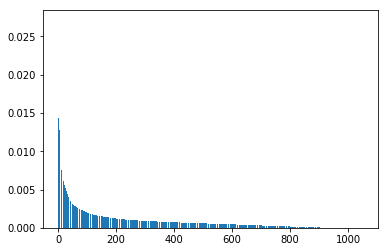

In [33]:
# création de la matrice 'bag_of_words'
docterm = make_docterm_matrix(tokenized_corpus, idf_transform=True)

svd = decomposition.TruncatedSVD(n_components=1050)
normalizer = preprocessing.Normalizer(copy=False)
lsa = pipeline.make_pipeline(svd, normalizer)
lsa.fit(docterm)
plt.bar(np.arange(1050), np.sort(svd.explained_variance_ratio_)[::-1])

In [92]:
svd = decomposition.TruncatedSVD(n_components=100)
lsa = pipeline.make_pipeline(svd, normalizer)
X = lsa.fit_transform(docterm)
print("SVD explained variance: {}%".format(int(svd.explained_variance_ratio_.sum()*100)))
km = cluster.KMeans(
        n_clusters=7,
        init="k-means++",
        max_iter=100,
        n_init=10,
    )

clusters = km.fit(X)

print("ARI: {:.3f}".format(metrics.adjusted_rand_score(labels, km.labels_)))

SVD explained variance: 46%
ARI: 0.330


In [93]:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = docterm.columns
for i in range(7):
    print("Cluster {}: ".format(i))
    print(" ".join([terms[ind] for ind in order_centroids[i, :10]]))
    print()

Cluster 0: 
blanket single abstract double quilt comforte multicolor floral raymond rajasthan

Cluster 1: 
combo set online denver yardley nike adidas playboy ice deo

Cluster 2: 
baby cotton towel girl detail fabric dress boy sleeve neck

Cluster 3: 
watch analog men discount india great woman online dial boy

Cluster 4: 
mug ceramic coffee prithish perfect rockmantra gift design loved safe

Cluster 5: 
inch pack laptop warranty box model feature color type material

Cluster 6: 
showpiece best price online kadhai usb lowest led brass handicraft



## IV.4 Visualisation 2D avec t-SNE

In [94]:
tsne = manifold.TSNE(perplexity=100, n_iter=2000)
clusters = tsne.fit_transform(X)

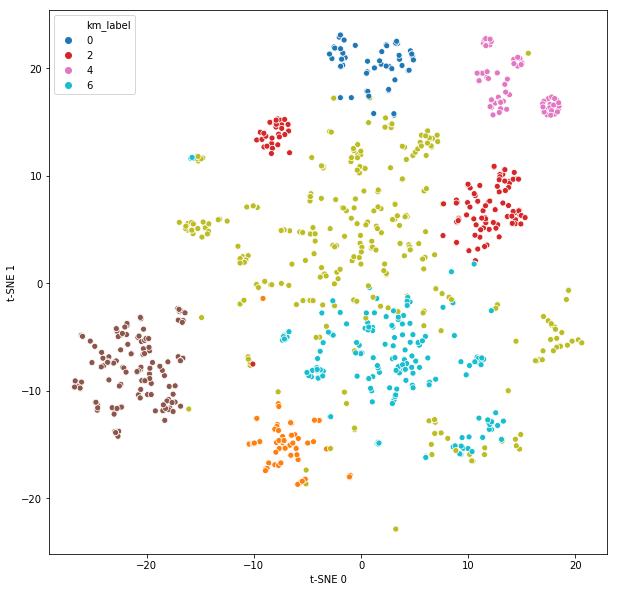

In [95]:
clust = pd.DataFrame(data=clusters, columns=["t-SNE 0", "t-SNE 1"])
km_labels = pd.Series(data=km.labels_, name="km_label")
df = pd.concat([clust, km_labels], axis=1)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue="km_label", palette='tab10')

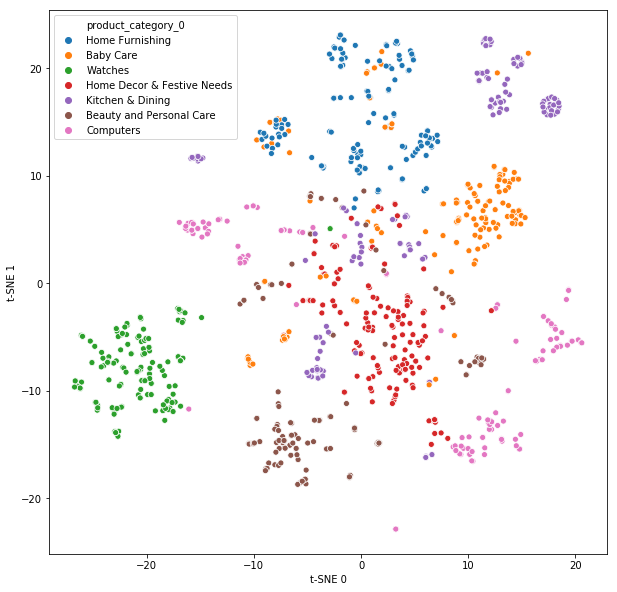

In [96]:
clust = pd.DataFrame(data=clusters, columns=["t-SNE 0", "t-SNE 1"])
df = pd.concat([clust, data.product_category_0], axis=1)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue="product_category_0")

## HDBSCAN Pipeline

In [130]:
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=20)
clusterer.fit(X)
hdbs_labels = clusterer.labels_

In [131]:
np.unique(hdbs_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

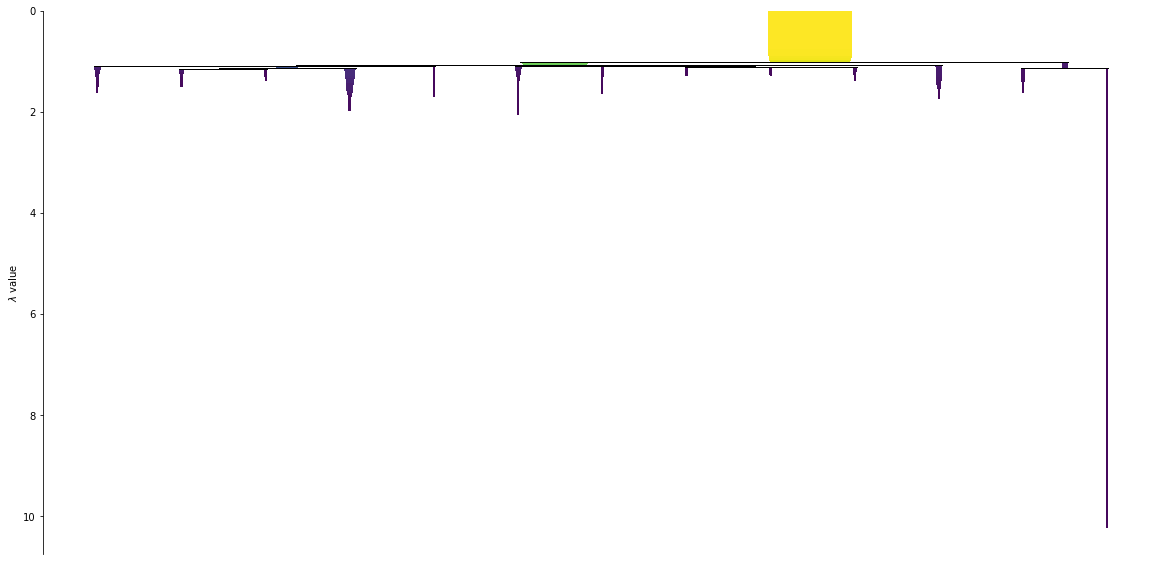

In [132]:
fig, ax = plt.subplots(figsize=(20, 10))
clusterer.condensed_tree_.plot(axis=ax, colorbar=False)

In [133]:
data["hdbs_labels"] = hdbs_labels

In [46]:
tsne = manifold.TSNE(perplexity=100, n_iter=2000)
clusters = tsne.fit_transform(X)

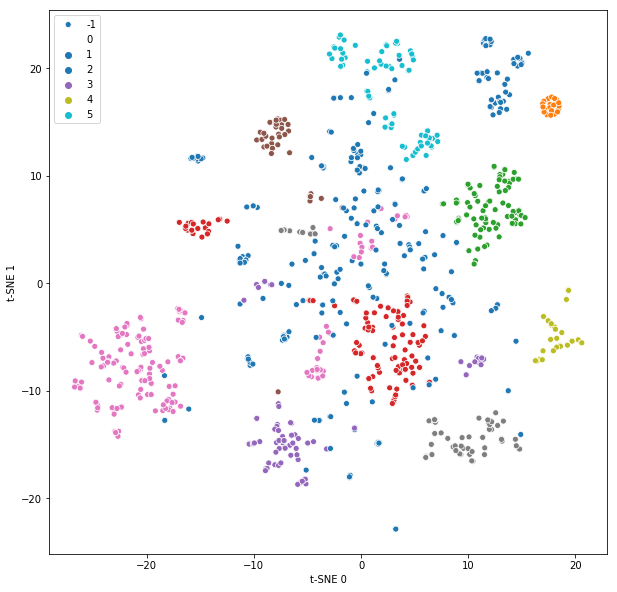

In [134]:
clust = pd.DataFrame(data=clusters, columns=["t-SNE 0", "t-SNE 1"])
df = pd.concat([clust, data.hdbs_labels], axis=1)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue="hdbs_labels", palette='tab10')
ax.legend(np.arange(len(np.unique(clusterer.labels_)))-1)

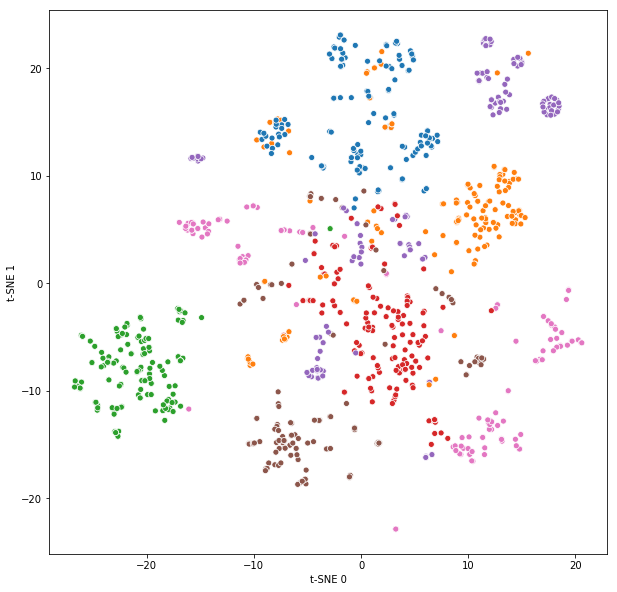

In [135]:
clust = pd.DataFrame(data=clusters, columns=["t-SNE 0", "t-SNE 1"])
df = pd.concat([clust, data.product_category_0], axis=1)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue="product_category_0", palette='tab10', legend=False)

In [136]:
# Encodage numérique des vraies catégories
print("ARI entre les étiquettes obtenues par HDBSCAN et les vraies étiquettes de niveau 0: {:.2f}"
      .format(metrics.adjusted_rand_score(labels, hdbs_labels)))

ARI entre les étiquettes obtenues par HDBSCAN et les vraies étiquettes de niveau 0: 0.38


In [114]:
# Encodage numérique des vraies catégories
le1 = preprocessing.LabelEncoder()
labels_1 = le1.fit_transform(data.product_category_1)
data['label_1'] = labels_1

print("ARI entre les étiquettes obtenues par HDBSCAN et les vraies étiquettes de niveau 1: {:.2f}"
      .format(metrics.adjusted_rand_score(labels_1, hdbs_labels)))

ARI entre les étiquettes obtenues par HDBSCAN et les vraies étiquettes de niveau 1: 0.07
